In [2]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

In [3]:
model = YOLO("Pre-trained Models/yolov8m-seg.pt")  # yolov8n-seg.pt # yolov8s-seg.pt # yolov8l-seg.pt # yolov8x-seg.pt


0: 384x640 6 cars, 1 bus, 1 truck, 3 traffic lights, 308.5ms
Speed: 5.6ms preprocess, 308.5ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)


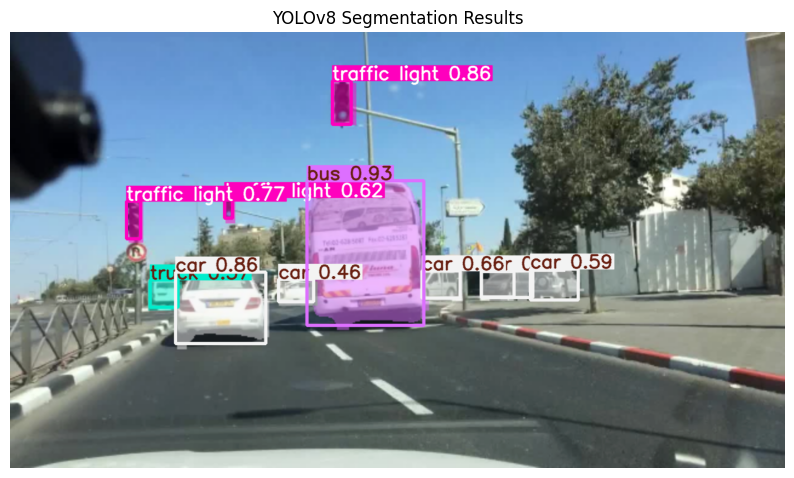

In [4]:
img = cv2.imread("assets/test/dashcam-train(550e9f1b-b49b2afa).jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = model(img_rgb)[0]  # Get the first result
plt.figure(figsize=(10, 6))
plt.imshow(results.plot())  # Plot the results
plt.title("YOLOv8 Segmentation Results")
plt.axis('off')
plt.show()

In [6]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
model_name = "nvidia/segformer-b2-finetuned-cityscapes-1024-1024"
feature_extractor = SegformerImageProcessor.from_pretrained(model_name)
model2 = SegformerForSemanticSegmentation.from_pretrained(model_name)

c:\Users\porip\Documents\Pouria Ar\PouriaEdu\University2\Master Thesis\Code\ragbaarnet-env\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Original image size: (1280, 720)
Logits shape: torch.Size([1, 19, 128, 128])
Upsampled logits shape: torch.Size([1, 19, 720, 1280])
Final predictions shape: (720, 1280)


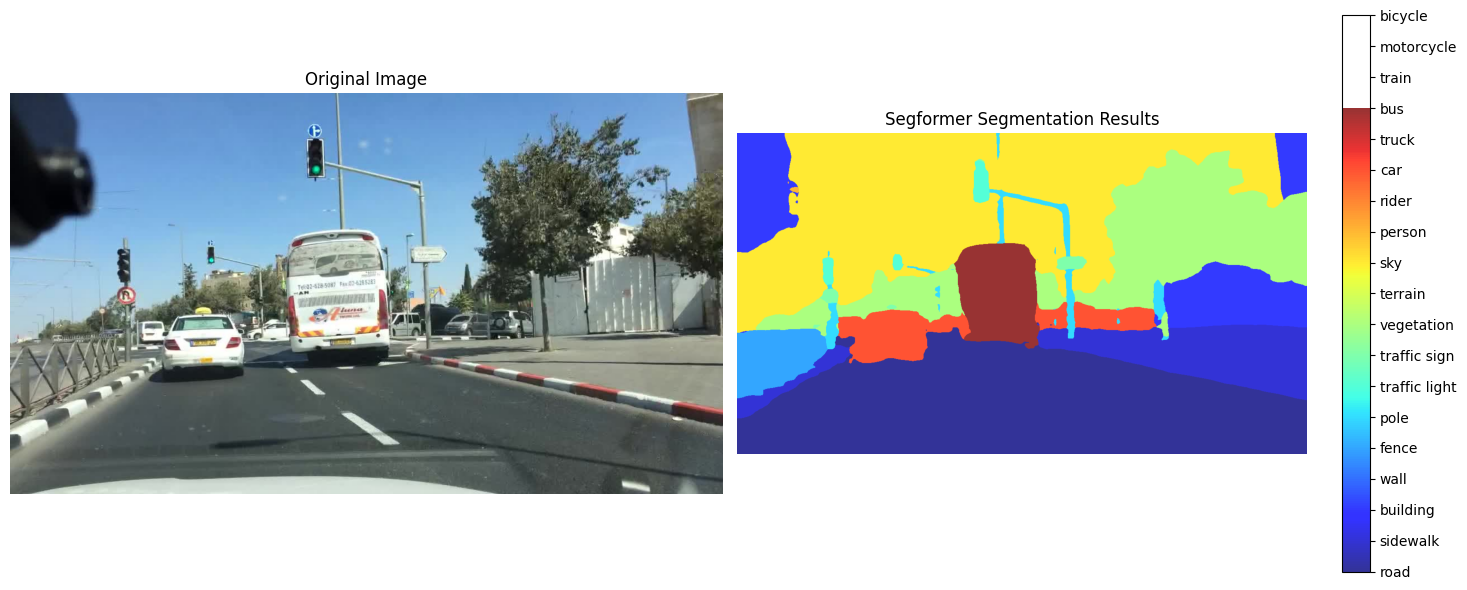

In [12]:
image = Image.open("assets/test/dashcam-train(550e9f1b-b49b2afa).jpg").convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model2(**inputs)
logits = outputs.logits  # [1, num_classes, height, width]

# Get original image size
original_size = image.size  # (width, height)
print(f"Original image size: {original_size}")
print(f"Logits shape: {logits.shape}")   # (height, width)

# Upsample logits to original image size
upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=(original_size[1], original_size[0]),  # (height, width)
    mode='bilinear',
    align_corners=False
)
print(f"Upsampled logits shape: {upsampled_logits.shape}")

# Get predictions from upsampled logits
preds = torch.argmax(upsampled_logits, dim=1).cpu().numpy()[0]
print(f"Final predictions shape: {preds.shape}")

# Cityscapes class labels for Segformer
cityscapes_labels = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light",
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car",
    "truck", "bus", "train", "motorcycle", "bicycle"
]

# Display both original image and segmentation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original image
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis('off')

# Segmentation mask
im = ax2.imshow(preds, cmap='jet', alpha=0.8)
ax2.set_title("Segformer Segmentation Results")
ax2.axis('off')

# Add colorbar with labels
cbar = plt.colorbar(im, ax=ax2)
cbar.set_ticks(range(len(cityscapes_labels)))
cbar.set_ticklabels(cityscapes_labels)

plt.tight_layout()
plt.show()